## Demo NB to show the TOF electronics computing

In [1]:
import sys
import numpy  as np
import pandas as pd
import antea.elec.tof_functions as tf
import matplotlib.pyplot as plt
from antea.io.mc_io import load_mcTOFsns_response

#### Parameters

In [2]:
SIPM        = {'n_sipms':3500, 'first_sipm':1000, 'tau_sipm':[100,15000]}
n_sipms     = SIPM['n_sipms']
first_sipm  = SIPM['first_sipm']
tau_sipm    = SIPM['tau_sipm']
TE_range    = [0.25]
TE_TDC      = TE_range[0]
time_window = 10000
time_bin    = 5
time        = np.arange(0, 80000, time_bin)
spe_resp    = tf.spe_dist(tau_sipm, time)

In [3]:
np.set_printoptions(threshold=sys.maxsize)
file_name     = '/Users/carmenromoluque/nexus_petit_analysis/PETit-ring/DAQ_antea/petit_ring_tof_high_stat.000.pet.h5'
tof_response  = load_mcTOFsns_response(file_name)
tof_waveforms = tof_response[tof_response.event_id == 0]
tdc_conv_table = tf.tdc_convolution(tof_waveforms, spe_resp, time_window, n_sipms, first_sipm, TE_TDC)
print(tdc_conv_table.shape)

tof_table  = np.zeros((time_window  + len(spe_resp)-1, n_sipms))
tof_table.shape

(25999, 3500)


(25999, 3500)

In [4]:
def no_convolve_tof(spe_resp, signal):
    no_conv_zeros = np.zeros(len(spe_resp)-1)
    no_conv_first = np.hstack([1., no_conv_zeros, np.zeros(len(signal)-1)])
    no_conv_res   = np.zeros(len(spe_resp)+len(signal)-1)
    pe_pos        = np.argwhere(signal > 0)
    pe_recov      = signal[pe_pos]
    for i in range(len(pe_recov)):
        desp     = np.roll(no_conv_first, pe_pos[i])
        no_conv_res = desp + no_conv_res
    return no_conv_res

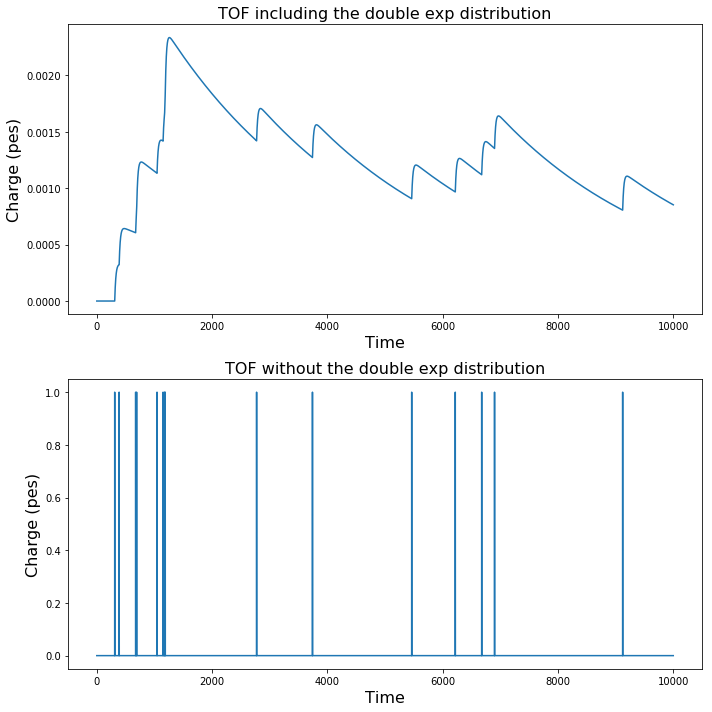

12.515290570182893
15.0


In [5]:
file_name = '/Users/carmenromoluque/nexus_petit_analysis/PETit-ring/DAQ_antea/petit_ring_tof_high_stat.000.pet.h5'
tof_wave  = load_mcTOFsns_response(file_name)

for evt in range(1):
    tof_waveforms = tof_wave[tof_wave.event_id == evt]
    pe_table  = np.zeros((time_window, n_sipms))
    for i, wf in tof_waveforms.iterrows():
        if wf.time_bin < time_window:
            s_id = - wf.sensor_id - first_sipm
            pe_table[wf.time_bin, s_id] = wf.charge
            
    conv_table    = np.zeros((len(pe_table) + len(spe_resp)-1, n_sipms))
    no_conv_table = np.zeros((len(pe_table) + len(spe_resp)-1, n_sipms))
    
    #for i in range(n_sipms):
    for i in range(91, 92):
        if np.count_nonzero(pe_table[0:time_window,i]):
            conv_table[:,i]    = tf.convolve_tof(spe_resp, pe_table[0:time_window,i]) ##len(conv_table[:,i]) = 25999
            zeros_spe_resp     = np.zeros(len(spe_resp))
            no_conv_table[:,i] = no_convolve_tof(zeros_spe_resp, pe_table[0:time_window,i])
            
            #normalization = sum(conv_table[:time_window,i])/sum(no_conv_table[:time_window,i])
            fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,10))
            ax1.plot(np.arange(0,time_window), conv_table[:time_window,i])#/normalization)
            ax2.plot(np.arange(0,time_window), no_conv_table[:time_window,i])
            #ax1.set_ylim(0,2)
            #ax2.set_ylim(0,2)
            ax1.set_ylabel('Charge (pes)', size=16)
            ax2.set_ylabel('Charge (pes)', size=16)
            ax1.set_xlabel('Time', size=16)
            ax2.set_xlabel('Time', size=16)
            ax1.set_title('TOF including the double exp distribution', size=16)
            ax2.set_title('TOF without the double exp distribution', size=16)
            plt.tight_layout()
            plt.show()

            print(np.sum(conv_table[:time_window,i]))
            print(np.sum(no_conv_table[:time_window,i]))

In [7]:
np.nonzero(no_convolve_tof(zeros_spe_resp, pe_table[0:time_window,91]))
#np.nonzero(convolve_tof(spe_resp, pe_table[0:time_window,91]))


(array([ 311,  388,  674,  691, 1045, 1150, 1176, 1187, 2772, 3741, 5462,
        6218, 6676, 6899, 9121]),)

### Translation from the matrix to a tof_waveform dataframe

In [ ]:
evt = 0
tof_waveforms_exp_dist = tf.translate_charge_matrix_to_wf_df(evt, tdc_conv_table, first_sipm)
tof_waveforms_exp_dist.head()

In [26]:
file_name = '/Users/carmenromoluque/nexus_petit_analysis/PETit-ring/DAQ_antea/petit_ring_tof_high_stat.000.pet.h5'
tof_wave  = load_mcTOFsns_response(file_name)

for evt in range(1):
    tof_waveforms = tof_wave[tof_wave.event_id == evt]
    pe_table  = np.zeros((time_window, n_sipms))
    for i, wf in tof_waveforms.iterrows():
        if wf.time_bin < time_window:
            s_id = - wf.sensor_id - first_sipm
            pe_table[wf.time_bin, s_id] = wf.charge
            
    conv_table    = np.zeros((len(pe_table) + len(spe_resp)-1, n_sipms))
    no_conv_table = np.zeros((len(pe_table) + len(spe_resp)-1, n_sipms))
    
    #for i in range(n_sipms):
    for i in range(91, 92):
        if np.count_nonzero(pe_table[0:time_window,i]):
            conv_table[:,i]    = tf.convolve_tof(spe_resp, pe_table[0:time_window,i]) ##len(conv_table[:,i]) = 25999
        list_wf = []
        for t in range(len(conv_table)):
            for s_id in range(conv_table.shape[1]):
                charge = conv_table[t,s_id]
                s_id = - s_id - first_sipm
                if charge > 0.:
                    list_wf.append(np.array([evt, s_id, t, charge]))
        a_wf = np.array(list_wf)
        keys = np.array(['event_id', 'sensor_id', 'time_bin', 'charge'])
        df = pd.DataFrame(a_wf, columns = keys) 
    print(df)
     

       event_id  sensor_id  time_bin    charge
0           0.0    -1091.0     312.0  0.050430
1           0.0    -1091.0     313.0  0.098384
2           0.0    -1091.0     314.0  0.143982
3           0.0    -1091.0     315.0  0.187340
4           0.0    -1091.0     316.0  0.228566
5           0.0    -1091.0     317.0  0.267765
6           0.0    -1091.0     318.0  0.305035
7           0.0    -1091.0     319.0  0.340471
8           0.0    -1091.0     320.0  0.374162
9           0.0    -1091.0     321.0  0.406192
10          0.0    -1091.0     322.0  0.436644
11          0.0    -1091.0     323.0  0.465595
12          0.0    -1091.0     324.0  0.493116
13          0.0    -1091.0     325.0  0.519278
14          0.0    -1091.0     326.0  0.544148
15          0.0    -1091.0     327.0  0.567788
16          0.0    -1091.0     328.0  0.590259
17          0.0    -1091.0     329.0  0.611617
18          0.0    -1091.0     330.0  0.631916
19          0.0    -1091.0     331.0  0.651209
20          0

In [10]:
tof_waveforms = tof_wave[tof_wave.event_id == 0]
tof_waveforms.head()

,event_id,sensor_id,time_bin,charge
0,0,-1268,367,1
1,0,-1268,536,1
2,0,-1268,539,1
3,0,-1268,892,1
4,0,-1268,951,1


In [ ]:
df0     = pd.DataFrame({})
keys = np.array(['event_id', 'sensor_id', 'time_bin', 'charge'])
df0[key] = vals
df = pd.concat((df, df0))
end = time.time()
print(end - start)